In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
from scipy import signal
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
from XSpect.XSpect_Processor import Peaks
from XSpect.XSpect_Processor import Background
from matplotlib.patches import Patch
import pickle


## Viewing Static XES Spectra

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1015522',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[0,50]]
xes.add_filter('xray','ipm',1.0E2)
xes.add_filter('simultaneous','ipm',1.0E2)
xes.add_filter('laser','ipm',1.0E2)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
#xes.run_parser(['112-114','116-117','121-125','128-132']) 
xes.run_parser(['112']) 
xes.laser=True
xes.verbose=True
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static_laser,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=43.25, R=250,  mm_per_pixel=0.05, d=0.981)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()


Starting parallel analysis with shot ranges.
Parsing run shots.
Run shots parsed.
Breaking into shot ranges with increment 2000.
Shot ranges broken.


Processing:   0%|          | 0/5 [00:00<?, ?Shot_Batch/s]

completed_filterscompleted_filters
completed_filters

completed_filters
entering aduentering aduentering aduentering adu



entering unnionentering unnionentering unnionentering unnion





Processing:  20%|██        | 1/5 [00:01<00:06,  1.69s/Shot_Batch]

Error in processing run 112: boolean index did not match indexed array along dimension 0; dimension is 1990 but corresponding boolean dimension is 1999
Error in processing run 112: boolean index did not match indexed array along dimension 0; dimension is 1985 but corresponding boolean dimension is 1999
Error in processing run 112: boolean index did not match indexed array along dimension 0; dimension is 1992 but corresponding boolean dimension is 1999
Error in processing run 112: boolean index did not match indexed array along dimension 0; dimension is 1995 but corresponding boolean dimension is 1999
completed_filters
entering adu
entering unnion


Processing: 100%|██████████| 5/5 [00:02<00:00,  2.33Shot_Batch/s]

Error in processing run 112: boolean index did not match indexed array along dimension 0; dimension is 904 but corresponding boolean dimension is 998
Parallel analysis with shot ranges completed.
Parallel analysis completed.
Total time: 2.18 seconds.
Parallel time (processing): 2.18 seconds.
Time per batch (on average): 0.44 seconds.
Time per core (on average): 0.54 seconds.
Batches per core (on average): 1.25.
Read bytes: 0.01 MB.
Write bytes: 39.26 MB.
Memory used: 1.39 MB.
Errors encountered: 5


IndexError: list index out of range

In [ ]:
xes.status

In [ ]:
np.shape(xes.analyzed_runs[2].epix_xray_not_laser_ROI_1)

In [ ]:
laser=xes.analyzed_runs[0].epix_simultaneous_laser_ROI_1
dark=xes.analyzed_runs[0].epix_xray_not_laser_ROI_1
epix=xes.analyzed_runs[0].epix
plt.plot(dark)
plt.plot(laser)
#plt.plot(epix)

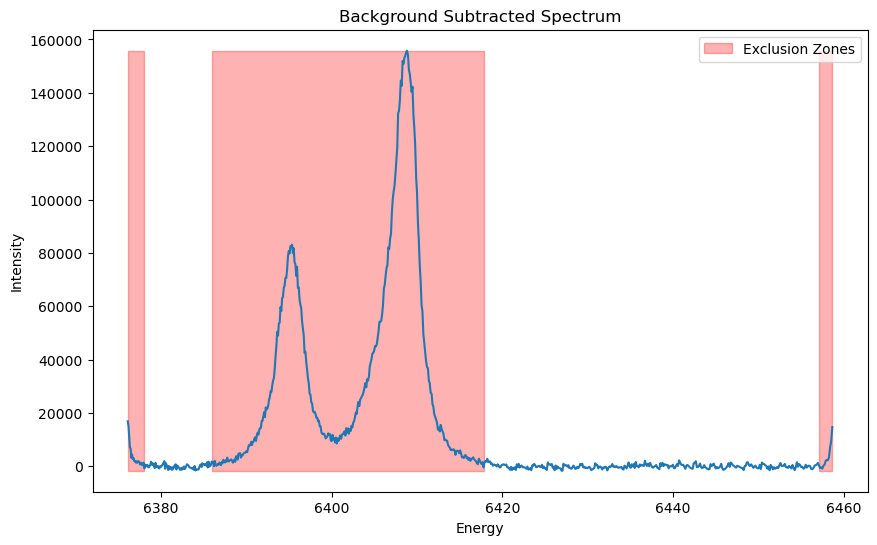

In [12]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,6402,6415)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,6402,6415)
exclusions= (
    (6368, 6378), #edge of detector
    (6386,6418), #Main peaks
    (6457,6465),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()


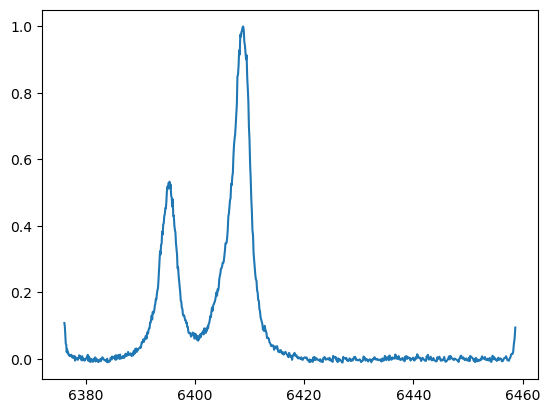

In [13]:
#First moment calculated after maximum peak normalized to 1
v.normalize_peak(6386,6418)
xes.first_moment=Peaks.first_moment(v.energy,v.normalized_peak,6402,6415)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.normalized_peak,6402,6415)
plt.plot(v.energy,v.normalized_peak)

Text(0, 0.5, 'Normalized Intensity')

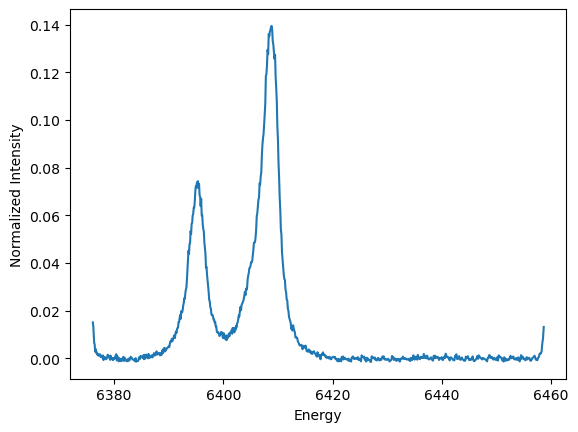

In [14]:
#Normalizes spectrum to make the area under in specified range equal to unity
v.normalize_spectrum(6386,6418)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')


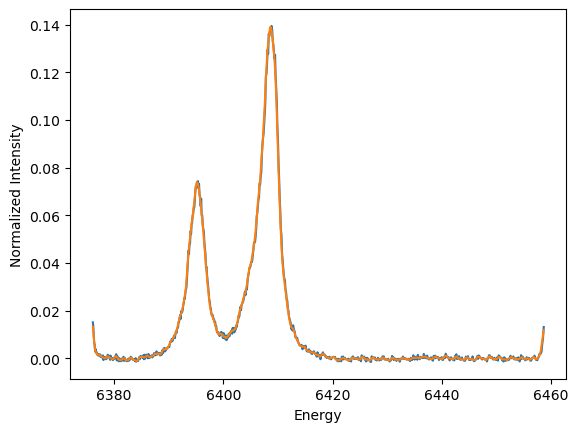

In [15]:
v.smoothed = signal.savgol_filter(v.normalized, window_length=10, polyorder=2, mode="nearest")
plt.plot(v.energy,v.normalized)
plt.plot(v.energy,v.smoothed)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')

#Pickles data and analysis files based on above code
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [16]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()

First Moment: 6408.0481155164
FWHM: 4.572660191093797
Run Number: 112
  Total: 8994
  X-ray Total: 8994
  Laser Total: 4499
  XES_Hits: 7144
  Percent_XES_Hits: 79.43%

Run Number: 113
  Total: 8994
  X-ray Total: 8994
  Laser Total: 4499
  XES_Hits: 7658
  Percent_XES_Hits: 85.15%

Run Number: 114
  Total: 8999
  X-ray Total: 8987
  Laser Total: 4488
  XES_Hits: 5674
  Percent_XES_Hits: 63.05%

Run Number: 116
  Total: 8994
  X-ray Total: 8994
  Laser Total: 4495
  XES_Hits: 7297
  Percent_XES_Hits: 81.13%

Run Number: 117
  Total: 6055
  X-ray Total: 6055
  Laser Total: 3026
  XES_Hits: 4866
  Percent_XES_Hits: 80.36%

Run Number: 121
  Total: 8991
  X-ray Total: 8978
  Laser Total: 4493
  XES_Hits: 6942
  Percent_XES_Hits: 77.21%

Run Number: 122
  Total: 4330
  X-ray Total: 4324
  Laser Total: 2164
  XES_Hits: 3761
  Percent_XES_Hits: 86.86%

Run Number: 123
  Total: 8995
  X-ray Total: 8982
  Laser Total: 4495
  XES_Hits: 6619
  Percent_XES_Hits: 73.59%

Run Number: 124
  Total: 8

In [8]:
#xes.run_parser(['77-89','91-92']) #Red
#xes.run_parser(['93-99','101-102','105-109']) #2s
#xes.run_parser(['112-114','116-117','121-125','128-132']) #1s
with open(f'data_{str(xes.runs)}.pkl', 'rb') as f:
    data_AlkB_O2_2s = pickle.load(f)
   
with open(f'analysis_{str(xes.runs)}.pkl', 'rb') as f:
    analysis_AlkB_O2_2s = pickle.load(f)

In [9]:
plt.plot(analysis_AlkB_Red.energy,analysis_AlkB_Red.normalized)
plt.plot(analysis_AlkB_O2_1s.energy,analysis_AlkB_O2_1s.normalized)
plt.plot(analysis_AlkB_O2_2s.energy,analysis_AlkB_O2_2s.normalized)



NameError: name 'analysis_AlkB_Red' is not defined

In [21]:
print('Red','1s','2s')
print(data_AlkB_Red.fwhm,data_AlkB_O2_1s.fwhm,data_AlkB_O2_2s.fwhm)
print(data_AlkB_Red.first_moment,data_AlkB_O2_1s.first_moment,data_AlkB_O2_2s.first_moment)

Red 1s 2s
4.755108014923971 4.572660191093797 4.6242412679605005
6408.181150255361 6408.0481155164 6408.117108026208


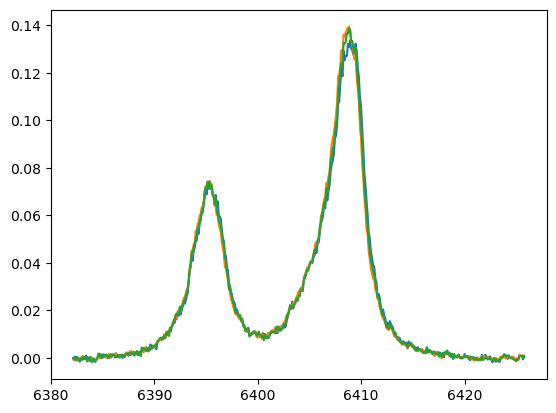

In [43]:
plt.plot(analysis_AlkB_Red.energy[70:500],analysis_AlkB_Red.normalized[70:500])
plt.plot(analysis_AlkB_O2_1s.energy[70:500],analysis_AlkB_O2_1s.normalized[70:500])
plt.plot(analysis_AlkB_O2_2s.energy[70:500],analysis_AlkB_O2_2s.normalized[70:500])

In [21]:
plt.

AttributeError: 'list' object has no attribute 'epix'

In [ ]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['ipm_dg2/sum'] 
names=['ipm']
xes.set_key_aliases(keys,names)
xes.hitfind=True
#xes.import_roi=[[0,-1]]
xes.rois=[[95,110]]
xes.add_filter('xray','ipm',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.adu_cutoff=3.0
xes.angle=0
xes.transpose=True
xes.pixels_to_patch=[382,383,384,385]#needed to change since detector is 90 degrees from standard. e.g. transposed above
xes.patch_mode='polynomial'
xes.run_parser(['230'])
start=time.time()
xes.primary_analysis_parallel_range(4,xes_experiment,method=xes.primary_analysis_static,increment=2000,verbose=False)
end=time.time()
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_static_spectra(xes_analysis=xes,xes_key='epix_ROI_1')
v.make_energy_axis(A=43.25, R=250,  mm_per_pixel=0.05, d=0.895)
plt.plot(v.energy,v.summed_xes)
xes.aggregate_statistics()

In [ ]:
xes.first_moment=Peaks.first_moment(v.energy,v.summed_xes,7030,7072)
xes.fwhm=Peaks.gaussian_fwhm(v.energy,v.summed_xes,7030,7072)
exclusions= (
    (6980, 6990), #edge of detector
    (7030,7070), #Main peaks
    (7076,7081),# other edge of detector
)
v.background_subtracted=Background.polynomial_subtraction(v.energy,v.summed_xes,4,exclusions)


plt.figure(figsize=(10, 6))
plt.plot(v.energy, v.background_subtracted, label='Background Subtracted')
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.title('Background Subtracted Spectrum')

for (x_start, x_end) in exclusions:
    plt.fill_between(v.energy, min(v.background_subtracted) - 1, max(v.background_subtracted) + 1, 
                     where=((v.energy >= x_start) & (v.energy <= x_end)), color='red', alpha=0.3)


exclusion_patch = Patch(color='red', alpha=0.3, label='Exclusion Zones')
plt.legend(handles=[exclusion_patch], loc='upper right')
plt.show()
with open(f'data_kb__{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_kb_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
v.normalize_spectrum(7030,7070)
plt.plot(v.energy,v.normalized)
plt.xlabel('Energy')
plt.ylabel('Normalized Intensity')
with open(f'data_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(xes, f)
with open(f'analysis_{str(xes.runs)}.pkl', 'wb') as f:
    pickle.dump(v, f)

In [ ]:
print(f'First Moment: {xes.first_moment}')
print(f'FWHM: {xes.fwhm}')
xes.print_run_statistics()